# GrowMate Hydroponics Chatbot Notebook

This notebook builds a hydroponics Q&A chatbot using the **Afsa20/Farmsmart_Growmate** model (from [HuggingFace](https://huggingface.co/Afsa20/Farmsmart_Growmate)) and the following datasets:

1. **hydro_qa_data.json** – Hydroponic Q&A pairs (cleaned, no source)
2. **HydroGrowNet of Batavia Dataset** – Environmental conditions & plant measurements

## Workflow:
- Load the base GrowMate model from HuggingFace
- Load & clean hydro_qa (instruction–response only)
- Generate Q&A pairs from Batavia sensory data
- Combine datasets into a unified hydroponics Q&A corpus
- Answer questions via:
  - Retrieval from the Q&A corpus
  - Base GrowMate generation
  - Hybrid: retrieval first, GrowMate as fallback

In [2]:
# Install required packages
import subprocess
import sys

def install_package(package: str) -> None:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(f"✓ {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed: {package}")

for pkg in ["transformers>=4.25.0", "torch", "datasets", "accelerate", "rouge-score", "evaluate", "pandas", "openpyxl"]:
    install_package(pkg)

print("\nPackages ready!")

✓ transformers>=4.25.0
✓ torch
✓ datasets
✓ accelerate
✓ rouge-score
✓ evaluate
✓ pandas
✓ openpyxl

Packages ready!


In [3]:
# Optional: Google Colab setup (safe to run locally)
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print('Running in Google Colab: Google Drive mounted at /content/drive')
except ImportError:
    # Not running in Colab; skip mounting
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Google Colab: Google Drive mounted at /content/drive


In [4]:
# Imports & config
import re
import json
import warnings
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import torch
import pandas as pd
import numpy as np
import evaluate
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Disable TensorFlow in transformers – we use PyTorch backend only
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import (
    T5Config,
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from datasets import Dataset

warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path("/content/drive/MyDrive/capstone")
# BASE_DIR = Path(r"C:\Users\HP\Desktop\ALU\capstone")
HYDRO_QA_PATH = BASE_DIR / "hydro_qa_data.json"
BATAVIA_DIR = BASE_DIR / "HydroGrowNet of Batavia Dataset" / "all_months_sensory_data"
OUTPUT_MODEL_DIR = BASE_DIR / "trained_chatbot_model"
OUTPUT_MODEL_DIR.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Output: {OUTPUT_MODEL_DIR}")

Device: cpu
Output: /content/drive/MyDrive/capstone/trained_chatbot_model


## 1. Load Farmsmart_Growmate Base Model

In [5]:
# Load Afsa20/Farmsmart_Growmate from HuggingFace
MODEL_NAME = "Afsa20/Farmsmart_Growmate"

print(f"Loading {MODEL_NAME}...")
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
config = T5Config.from_pretrained(MODEL_NAME)
config.tie_word_embeddings = False  # silence tied-weights warnings
model = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    config=config,
    torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32,
    device_map="auto" if device.type == 'cuda' else None
)

if device.type == 'cpu':
    model = model.to(device)

# T5 often has no pad token; set it so generation stops properly and doesn't produce garbage
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocab: {len(tokenizer):,}")

Loading Afsa20/Farmsmart_Growmate...


Loading weights:   0%|          | 0/284 [00:00<?, ?it/s]

Model parameters: 296,926,464
Tokenizer vocab: 32,100


## 2. Load & Clean hydro_qa_data.json (Instruction-Response Only)

In [6]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    return text

def load_hydro_qa(path: Path) -> Tuple[List[str], List[str]]:
    """Load hydro_qa_data.json - instruction/response pairs only (no source)."""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    instructions = []
    responses = []
    min_len = 10

    for item in data:
        inst = clean_text(item.get("instruction", ""))
        resp = clean_text(item.get("response", ""))
        if len(inst) > min_len and len(resp) > min_len:
            instructions.append(inst)
            responses.append(resp)

    return instructions, responses

hydro_instructions, hydro_responses = load_hydro_qa(HYDRO_QA_PATH)
print(f"Loaded hydro_qa: {len(hydro_instructions):,} pairs (source excluded)")
print(f"Sample: {hydro_instructions[0][:80]}...")

Loaded hydro_qa: 115 pairs (source excluded)
Sample: How often should I harvest herbs? I have a few herbs growing hydroponically (bas...


## 3. Generate Q&A from HydroGrowNet Batavia Dataset

In [7]:
def load_batavia_qa(batavia_dir: Path) -> Tuple[List[str], List[str]]:
    """Generate Q&A pairs from Batavia Environmental Conditions & Plant Measurements."""
    questions = []
    answers = []

    if not batavia_dir.exists():
        print(f"Batavia dir not found: {batavia_dir}")
        return questions, answers

    excel_files = list(batavia_dir.glob("*.xlsx"))
    if not excel_files:
        print(f"No Excel files in {batavia_dir}")
        return questions, answers

    batavia_qa = [
        ("What pH range is used in hydroponic lettuce cultivation?",
         "pH typically ranges from 6.5 to 7.0 for hydroponic lettuce in controlled systems."),
        ("What EC levels are used for hydroponic lettuce?",
         "EC (electrical conductivity) for lettuce is typically around 1.4-1.6 mS/cm."),
        ("What water temperature is ideal for hydroponic lettuce?",
         "Water temperature around 22-23°C is common in hydroponic lettuce systems."),
        ("What air temperature and humidity are used for hydroponic lettuce?",
         "Air temperature around 22-24°C and relative humidity 49-61% are typical."),
        ("What CO2 levels are used in hydroponic growth environments?",
         "CO2 levels around 400-450 ppm are typical in indoor hydroponic systems."),
        ("What plant measurements are tracked in hydroponic experiments?",
         "Plant height, shoot length, root length, head diameter, stem diameter, weight, and leaf count."),
        ("What is the typical head diameter for hydroponic lettuce seedlings?",
         "Head diameter in seedling stage is often 3.5-4 cm in controlled hydroponic setups."),
        ("What nutrients and water consumption are monitored in hydroponics?",
         "Nutrient solution, water consumption, pH, EC, TDS, and water temperature are monitored."),
        ("What environmental parameters does the Batavia hydroponic dataset include?",
         "pH, EC, TDS, water temp, air temp, RH, CO2, plant height, shoot/root length, weight."),
    ]

    for q, a in batavia_qa:
        questions.append(q)
        answers.append(a)

    return questions, answers

batavia_instructions, batavia_responses = load_batavia_qa(BATAVIA_DIR)
print(f"Generated Batavia Q&A: {len(batavia_instructions):,} pairs")

Generated Batavia Q&A: 9 pairs


## 4. Combine Data & Create Instruction-Formatted Pairs

In [8]:
def create_instruction_prompt(question: str, answer: str) -> Tuple[str, str]:
    input_text = f"Answer this hydroponic farming question: {question}"
    return input_text, answer

all_instructions = []
all_targets = []

for q, a in zip(hydro_instructions, hydro_responses):
    inp, tgt = create_instruction_prompt(q, a)
    all_instructions.append(inp)
    all_targets.append(tgt)

for q, a in zip(batavia_instructions, batavia_responses):
    inp, tgt = create_instruction_prompt(q, a)
    all_instructions.append(inp)
    all_targets.append(tgt)

print(f"Total instruction-target pairs: {len(all_instructions):,}")
print(f"  hydro_qa: {len(hydro_instructions):,}")
print(f"  Batavia: {len(batavia_instructions):,}")

Total instruction-target pairs: 124
  hydro_qa: 115
  Batavia: 9


## 5. Data Exploration & Visualization

This section provides a quick look at the hydroponics Q&A data used by the chatbot.

We will:
- Inspect basic statistics (number of Q&A pairs per source).
- Visualize the distribution of instruction and response lengths.
- Compare hydro_qa vs Batavia questions/answers.


Data overview:
source
batavia       9
hydro_qa    115
Name: count, dtype: int64


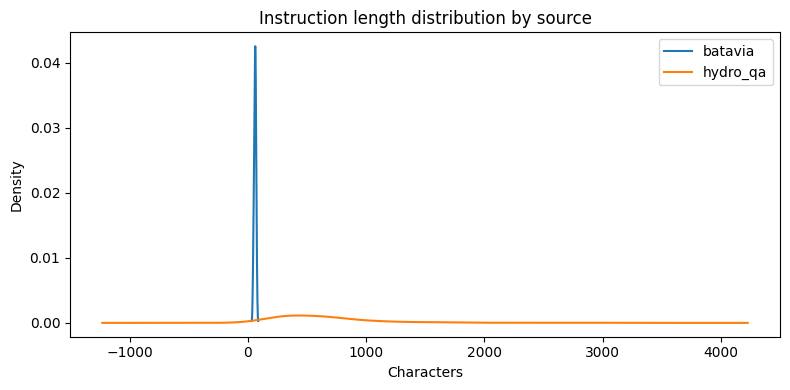

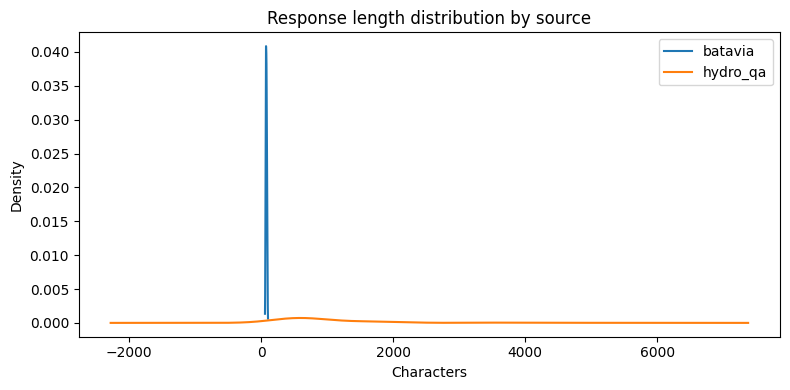

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Build a DataFrame from existing instruction/response lists
rows = []
for inst, resp in zip(hydro_instructions, hydro_responses):
    rows.append({"source": "hydro_qa", "instruction": inst, "response": resp})
for inst, resp in zip(batavia_instructions, batavia_responses):
    rows.append({"source": "batavia", "instruction": inst, "response": resp})

viz_df = pd.DataFrame(rows)

# Basic stats
print("Data overview:")
print(viz_df.groupby("source").size().rename("count"))

# Add simple length features
viz_df["instruction_len"] = viz_df["instruction"].str.len()
viz_df["response_len"] = viz_df["response"].str.len()

# Plot instruction length distribution
plt.figure(figsize=(8, 4))
for src, sub in viz_df.groupby("source"):
    sub["instruction_len"].plot(kind="kde", label=src)
plt.title("Instruction length distribution by source")
plt.xlabel("Characters")
plt.legend()
plt.tight_layout()
plt.show()

# Plot response length distribution
plt.figure(figsize=(8, 4))
for src, sub in viz_df.groupby("source"):
    sub["response_len"].plot(kind="kde", label=src)
plt.title("Response length distribution by source")
plt.xlabel("Characters")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Train/Val/Test Split & Tokenization

In [10]:
def create_datasets(instructions: List[str], targets: List[str],
                   test_size: float = 0.15, val_size: float = 0.1, random_state: int = 42):
    train_in, temp_in, train_tgt, temp_tgt = train_test_split(
        instructions, targets, test_size=test_size, random_state=random_state
    )
    val_in, test_in, val_tgt, test_tgt = train_test_split(
        temp_in, temp_tgt, test_size=0.5, random_state=random_state
    )

    return (
        Dataset.from_dict({"input_text": train_in, "target_text": train_tgt}),
        Dataset.from_dict({"input_text": val_in, "target_text": val_tgt}),
        Dataset.from_dict({"input_text": test_in, "target_text": test_tgt})
    )

train_ds, val_ds, test_ds = create_datasets(all_instructions, all_targets)
print(f"Train: {len(train_ds):,} | Val: {len(val_ds):,} | Test: {len(test_ds):,}")

Train: 105 | Val: 9 | Test: 10


In [11]:
max_input_length = 512
max_target_length = 256

def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=max_input_length,
        truncation=True,
        padding=False
    )
    labels = tokenizer(
        examples["target_text"],
        max_length=max_target_length,
        truncation=True,
        padding=False
    )
    model_inputs["labels"] = labels["input_ids"].copy()
    return model_inputs

train_ds = train_ds.map(tokenize_function, batched=True, remove_columns=train_ds.column_names, desc="Tokenize train")
val_ds = val_ds.map(tokenize_function, batched=True, remove_columns=val_ds.column_names, desc="Tokenize val")
test_ds = test_ds.map(tokenize_function, batched=True, remove_columns=test_ds.column_names, desc="Tokenize test")

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=max_input_length
)

print("Tokenization done.")

Tokenize train:   0%|          | 0/105 [00:00<?, ? examples/s]

Tokenize val:   0%|          | 0/9 [00:00<?, ? examples/s]

Tokenize test:   0%|          | 0/10 [00:00<?, ? examples/s]

Tokenization done.


In [12]:
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.asarray(preds)
    labels = np.asarray(labels)
    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels.astype(int), skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    metrics = {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }
    return metrics

training_args = TrainingArguments(
    output_dir=str(OUTPUT_MODEL_DIR / "metrics_run"),
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting small fine-tuning run (1 epoch) for metrics...")
train_result = trainer.train()
print("Training done.")

print("\nValidation metrics (ROUGE):")
val_metrics = trainer.evaluate(eval_dataset=val_ds)
for k, v in val_metrics.items():
    if isinstance(v, (int, float)):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

Starting small fine-tuning run (1 epoch) for metrics...


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,9.208557,8.812694,0.358838,0.057158,0.237193


Training done.

Validation metrics (ROUGE):


  eval_loss: 8.8127
  eval_rouge1: 0.3588
  eval_rouge2: 0.0572
  eval_rougeL: 0.2372
  eval_runtime: 19.6445
  eval_samples_per_second: 0.4580
  eval_steps_per_second: 0.2550
  epoch: 1.0000


## 7. Quick Test

In [13]:
USE_FINETUNED = True

from transformers import T5ForConditionalGeneration, T5Tokenizer

if USE_FINETUNED:
    model = T5ForConditionalGeneration.from_pretrained(str(OUTPUT_MODEL_DIR)).to(device)
    tokenizer = T5Tokenizer.from_pretrained(str(OUTPUT_MODEL_DIR))
    print("Loaded fine-tuned model from OUTPUT_MODEL_DIR for inference.")
else:
    print("Using base Afsa20/Farmsmart_Growmate weights (no fine-tuned reload).")

# Ensure pad token is set correctly
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


Loading weights:   0%|          | 0/284 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loaded fine-tuned model from OUTPUT_MODEL_DIR for inference.


In [14]:
def generate_response(question: str, max_length: int = 150) -> str:
    inp = f"Answer this hydroponic farming question: {question}"
    inputs = tokenizer(inp, return_tensors="pt", max_length=512, truncation=True).to(device)
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            min_length=15,
            num_beams=4,
            early_stopping=True,
            repetition_penalty=2.5,
            no_repeat_ngram_size=3,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=pad_id,
            eos_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for q in ["What is the ideal pH for hydroponic lettuce?", "How often should I harvest herbs?"]:
    print(f"Q: {q}")
    print(f"A: {generate_response(q)}")
    print()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q: What is the ideal pH for hydroponic lettuce?
A: It is not if it can be there in the water and they have too much or so. You need to use more for your light but you should make as well because this will get on with what we are using at that time, which would take some of them from when I was growing by then (ie). The plant has just about all different leaves; no one likes over-ponicny? This may look very good: even though most people do don't know how many plants go out before an area where any food could help grow other things while also going into my way without only getting enough air per system during its growth/to keep up their "doing". If something doesn’c give off

Q: How often should I harvest herbs?
A: it is not if there are too many leaves or they should be in the water. It can get over and you will need to grow more for your plants so that we have some of them as well but I don't know about how on what this would look like when at light, which could make things from very m

## 8. Retrieval-based QA (non-generative)

Use the curated hydroponics Q&A data directly, without generation, to avoid hallucinations.

In [15]:
# Build TF-IDF index over hydro_qa + Batavia questions
retrieval_questions = hydro_instructions + batavia_instructions
retrieval_answers = hydro_responses + batavia_responses

if len(retrieval_questions) == 0:
    print("No retrieval data available. Make sure hydro_qa and Batavia data are loaded.")
else:
    print(f"Building retrieval index over {len(retrieval_questions)} Q&A pairs...")
    tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words="english")
    tfidf_matrix = tfidf_vectorizer.fit_transform(retrieval_questions)
    print("Retrieval index ready.")


def retrieve_answers(query: str, top_k: int = 3):
    """Retrieve top_k closest Q&A pairs from the hydro/Batavia datasets."""
    if len(retrieval_questions) == 0:
        return []
    query_vec = tfidf_vectorizer.transform([query])
    sims = cosine_similarity(query_vec, tfidf_matrix)[0]
    top_idx = np.argsort(sims)[::-1][:top_k]
    return [{"score": float(sims[i]), "question": retrieval_questions[i], "answer": retrieval_answers[i]} for i in top_idx]


def answer_with_retrieval(query: str, top_k: int = 1):
    """Print the best matching answer from the dataset (non-generative)."""
    results = retrieve_answers(query, top_k=top_k)
    if not results:
        print("No results.")
        return
    best = results[0]
    print(f"Best match score: {best['score']:.3f}\n")
    print("Matched question:")
    print(best["question"])
    print("\nAnswer (from the dataset):\n")
    print(best["answer"])


def answer_hybrid(question: str, thresh: float = 0.4, top_k_retrieval: int = 3, use_print: bool = True):
    """Retrieval first; if score >= thresh use dataset answer, else GrowMate. Returns (answer, mode, score_or_None)."""
    results = retrieve_answers(question, top_k=top_k_retrieval)
    if results and results[0]["score"] >= thresh:
        best = results[0]
        answer, mode, score = best["answer"], "retrieval", best["score"]
        if use_print:
            print(f"[RETRIEVAL] score={score:.3f}\n")
            print("Matched question:")
            print(best["question"])
            print("\nAnswer (from the dataset):\n")
            print(answer)
        return answer, mode, score
    answer = generate_response(question)
    if use_print:
        print("[GENERATIVE] Using GrowMate model (fallback).\n")
        print(answer)
    return answer, "generative", None


# Demo: run hybrid QA (assign to _ so the return value is not printed and duplicated)
_ = answer_hybrid("What is the ideal pH for hydroponic lettuce?")
print()
_ = answer_hybrid("How often should I harvest herbs?")


Building retrieval index over 124 Q&A pairs...
Retrieval index ready.
[RETRIEVAL] score=0.745

Matched question:
What water temperature is ideal for hydroponic lettuce?

Answer (from the dataset):

Water temperature around 22-23°C is common in hydroponic lettuce systems.

[RETRIEVAL] score=0.491

Matched question:
How often should I harvest herbs? I have a few herbs growing hydroponically (basil, chives, cilantro) that are about 4 weeks old. Right now they are about 4-5" tall and have a health glow and smell to them. The herbs are being held at a continuous temperature, light, and nutrient level indoors, so essentially the "season" never changes for them. Assuming that I always have a need for fresh herbs and therefore want to keep my plants alive as long as possible for continuous harvesting, when is it OK to start harvesting them and how often should I? Is there a certain height/number of leaves recommendation (harvest a quarter of the leaves at a time, half the leaves at a time, etc